<a href="https://colab.research.google.com/github/aagarwal17/datasci-207-arun/blob/main/07_Decision_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research.

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples.

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.

# FILL IN CODE HERE #
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/EuroSAT/EuroSAT" # replace with your path

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [4]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data

    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)

    '''
    ## load images and labels
    # FILL IN CODE HERE #
    images_list = []
    labels_list = []

    # Iterating over each folder/land cover class, then over each image
    for class_name in sorted(os.listdir(path_to_data)):
        class_path = os.path.join(path_to_data, class_name)
        if os.path.isdir(class_path):
            for img_filename in os.listdir(class_path):
                img_path = os.path.join(class_path, img_filename)
                img = load_img(img_path, target_size=(64, 64))
                img_array = img_to_array(img)
                images_list.append(img_array)
                labels_list.append(class_name)

    images = np.array(images_list)
    labels = np.array(labels_list)

    return images, labels

In [5]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

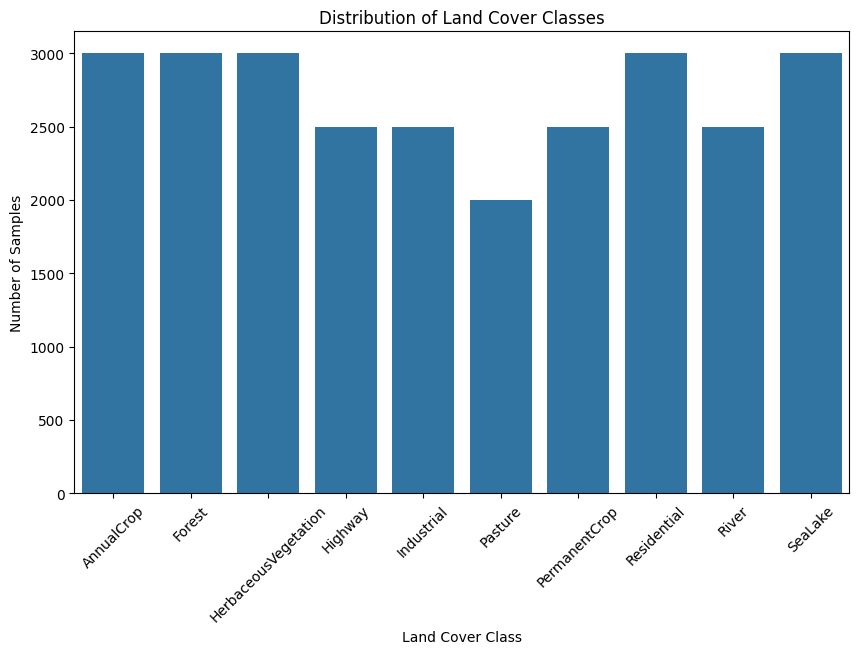

In [6]:
# FILL IN CODE HERE #

data = pd.DataFrame(labels, columns=["Land Cover Class"])
plt.figure(figsize=(10,6))
sns.countplot(data=data, x="Land Cover Class", order=sorted(data["Land Cover Class"].unique()))
plt.title("Distribution of Land Cover Classes")
plt.xlabel("Land Cover Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

Comment on class balance: [The dataset has approximately equal numbers of samples for each of the 10 classes (between 2000-3000 images per class), which indicates that the classes are relatively balanced. This is at least one of the most balanced datasets we have worked with in a while.]

Plotting the overall class distribution does not compromise the "blindness" of the test data because it only provides an understanding of how the data is distributed among classes. It does not reveal any specific information that would be used to tune the model or influence the training process. The test set remains untouched during this EDA, ensuring that its integrity is maintained for unbiased evaluation.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

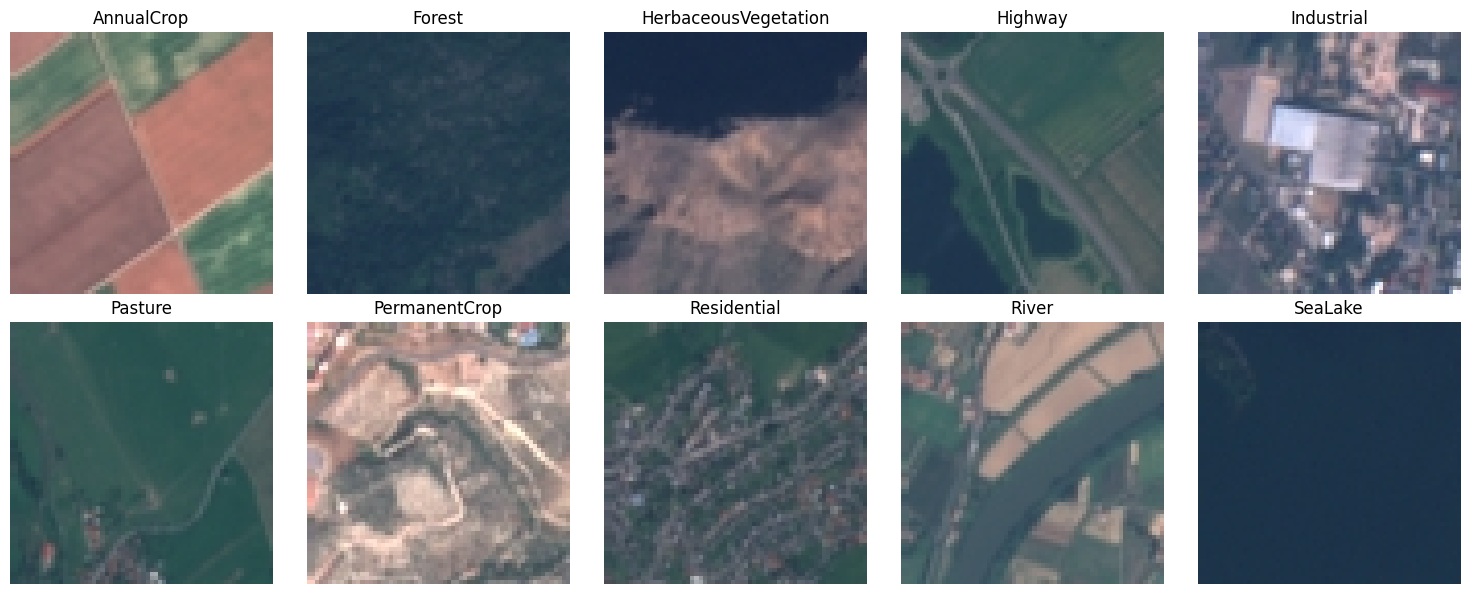

In [7]:
# FILL IN CODE HERE #
unique_classes = sorted(np.unique(labels))
plt.figure(figsize=(15, 6))
for i, cls in enumerate(unique_classes):
    idx = np.where(labels == cls)[0][0] #first image in each class
    plt.subplot(2, len(unique_classes)//2 + len(unique_classes)%2, i+1)
    plt.imshow(images[idx].astype('uint8'))
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

Most confused land classes: [The land classes that the Decision Tree Classifier will most likely confuse are those that are very subtely different in visual appearance (as the classifier makes the splits based on these differences). That is, if two classes have images that look very similar or (contextually would be very similar) based on color distributions or structural features (ex: Residential and Industrial covers may look the same in some cases), the classifier may get them confused. Residential and Industrial covers may look the same in some cases based on the infrastructure/lack of distinguishing structural features. Also, while not shown in the example above, herbaceous vegetation and pasture will both have a lot of green or similar color distributions, making them likely to be misclassified/confused. Forest and Pasture both have a lot of green as well. Finally, while again not demonstrted in the example above, river and sea/lake covers are both water classes that will have lots of blue and similar texture patterns for water, so the classifier can again misclassify between these two covers.]

---
### Step 3: Data preprocessing

Encode labels

In [8]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [9]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.

    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    # FILL IN CODE HERE #
    num_samples = images.shape[0]
    permutation = np.random.permutation(num_samples)
    images_shuffled = images[permutation]
    labels_shuffled = labels[permutation]

    # create data splits
    # FILL IN CODE HERE #
    train_size = int(split[0] * num_samples)
    val_size = int(split[1] * num_samples)
    # Test size will be the remainder of the samples

    X_train = images_shuffled[:train_size]
    y_train = labels_shuffled[:train_size]

    X_val = images_shuffled[train_size:train_size + val_size]
    y_val = labels_shuffled[train_size:train_size + val_size]

    X_test = images_shuffled[train_size + val_size:]
    y_test = labels_shuffled[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of val labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of val labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation.

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only:
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [11]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;

    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    data_partition (str): "train"

    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)

    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # image augmentation on training data
    if data_partition=="train":
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y)

        # Adjust brightness
        X_augm = tf.image.adjust_brightness(X_tensor, delta=DELTA)
        # Adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR)
        # Random flip
        X_augm = tf.image.flip_left_right(X_augm)

        # Concatenate original X and augmented X_aug data
        X_tensor = tf.concat([X_tensor, X_augm], axis=0)
        # The labels remain the same for augmented images, so we duplicate them
        y_tensor = tf.concat([y_tensor, y_tensor], axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X_tensor)[0], dtype=tf.int32))
        X = tf.gather(X_tensor, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y_tensor, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale image by dividing each pixel by 255.0
    X = X / 255.0

    return X, y

Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): [It is important to add augmented images to the training data because the quantity and diversity of data significantly impact the performance of a model. By artificially inflating the training data with augmentations—such as adjusting brightness, contrast, and flipping images as we do above—we create altered versions of the original data without changing their labels. This not only increases the size of the training set but also helps the model generalize better by learning invariant features, reducing the risk of overfitting. We leave the validation and test sets unaugmented to reflect the real-world data and to provide a consistent benchmark for model evaluation. This ensures that the performance truly indicates how the model will perform on new, unseen data.]

In [12]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [13]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Training Accuracy: 0.4717901234567901
Validation Accuracy: 0.44851851851851854
Confusion Matrix:
 [[261   8 135   7  25  21  45  57  29  21]
 [  0 482   1   0   0  23   0   7  10  83]
 [ 59  13 282   4  17  26  35 118  34   7]
 [ 57  32 116  15  16  44  13 106  62  13]
 [ 61   0  78   3 210  10  31  83   5   6]
 [  2  38  53   3   0 201   0  48  37  18]
 [158   3 151   3  19  20  61  95   8   3]
 [ 58   1 154   8  39  21  34 278  14  11]
 [ 13  70  54  18   8  41   6  65 170  38]
 [  0  65  23   0   3  14   0  18  22 462]]


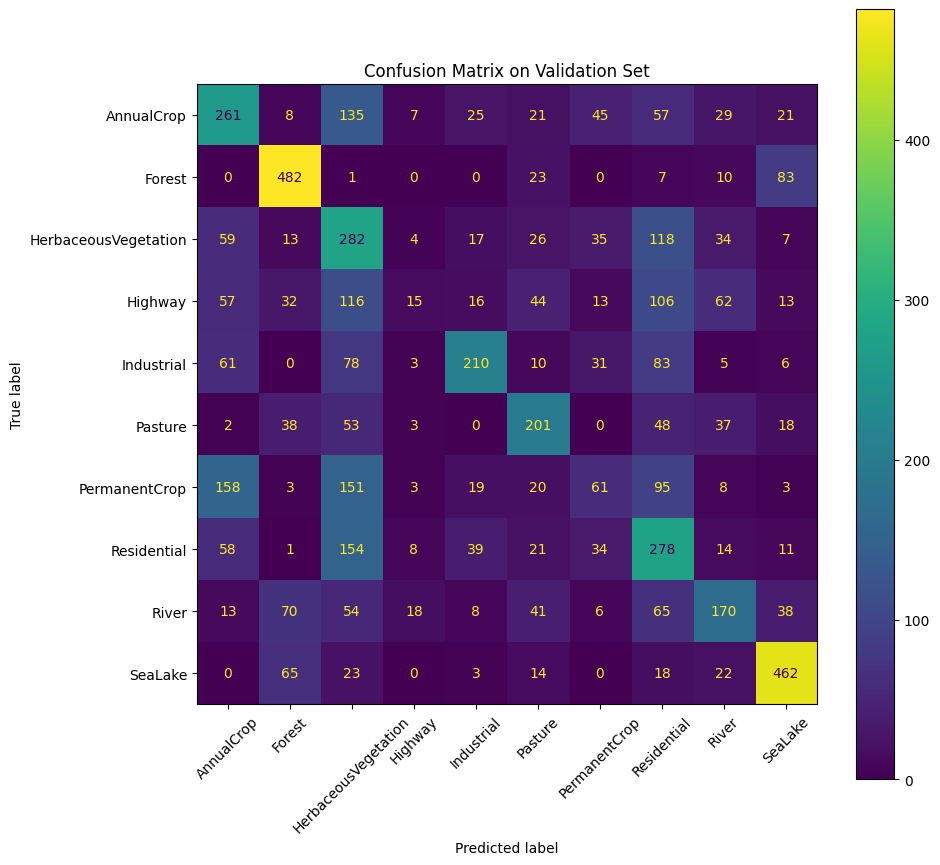

In [14]:
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier

# Training the RandomForestClassifier with given hyperparameters:
clf = RandomForestClassifier(n_estimators=2, n_jobs=1, random_state=1234, max_depth=8)
clf.fit(X_train_re, y_train)
y_train_pred = clf.predict(X_train_re)
y_val_pred = clf.predict(X_val_re)

# Evaluate accuracies on train and validation data:
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Compute the confusion matrix on the validation data:
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title("Confusion Matrix on Validation Set")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Compute per-class accuracy for the baseline model using its confusion matrix
baseline_per_class_acc = np.diag(cm)/np.sum(cm, axis=1)

# Create df to compare the per-class accuracies and improvements
df_compare = pd.DataFrame({
    'Class': encoder.classes_,
    'Baseline Accuracy': baseline_per_class_acc,
})

# Sort by improved accuracy to see most confused classes
df_compare_sorted = df_compare.sort_values(by='Baseline Accuracy', ascending=True)
df_compare_sorted

,Class,Baseline Accuracy
3,Highway,0.031646
6,PermanentCrop,0.117083
8,River,0.351967
0,AnnualCrop,0.428571
4,Industrial,0.431211
7,Residential,0.449838
2,HerbaceousVegetation,0.473950
5,Pasture,0.502500
9,SeaLake,0.761120
1,Forest,0.795380


Comment on model accuracy on training vs. validation data: [The baseline model achieves a training accuracy of approximately 47.18% and a validation accuracy of about 44.85%. This close proximity suggests that the model performs consistently across both sets, with only a slight drop from training to validation, which is to be expected with most datasets. However, both accuracies are relatively low, indicating that the model overall is not capturing the necessary complexity of the data to make more accurate predictions. We will need to refine the model.]


Does the model generalize well?: [As sugested by the previous question's answer, while the small difference between the training and validation accuracies implies that the model does not overfit and generalizes consistently, the overall low accuracy on both datasets means the model is still not performing well. That is, the model is failing to learn sufficient discriminative features from the data and then does not generalize well to the patterns/complexities of the land cover types.]

Comment on the classes that the model confuses the most: [By analzying the confusion matrix and dataframe created of per-class accuracies, we see that the model struggles significantly with certain classes, specifically 'Highway' with an accuracy of only about 3.16%, 'PermanentCrop' at around 11.71%, and 'River' at approximately 35.20%. These results suggest that the model frequently misclassifies images from these classes, likely due to overlapping visual characteristics or insufficient distinctive features. These poor performing class classifications make a bit of sense as Crops and highway covers can look dramatically different picture to picture in comparison to the other land covers. River comes at a bit of suprise to me, but of course that is the one with a bit higher accuracy (of course still low). Classes like 'SeaLake' and 'Forest' are recognized with much higher accuracy (possibly because these are classes with mostly similar color distributions of all blue or green, respectively.")

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines:
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Run with parameters: n_estimators=50, max_depth=6, min_samples_split=10, min_samples_leaf=3
Training Accuracy: 52.31%, Validation Accuracy: 49.13%, Difference: 3.19%
---------------------------------------------------------------------
Run with parameters: n_estimators=50, max_depth=6, min_samples_split=10, min_samples_leaf=5
Training Accuracy: 52.26%, Validation Accuracy: 49.17%, Difference: 3.09%
---------------------------------------------------------------------
Run with parameters: n_estimators=50, max_depth=6, min_samples_split=10, min_samples_leaf=8
Training Accuracy: 52.29%, Validation Accuracy: 48.98%, Difference: 3.31%
---------------------------------------------------------------------
Run with parameters: n_estimators=50, max_depth=6, min_samples_split=10, min_samples_leaf=10
Training Accuracy: 52.27%, Validation Accuracy: 49.04%, Difference: 3.23%
---------------------------------------------------------------------
Run with parameters: n_estimators=50, max_depth=6, min_

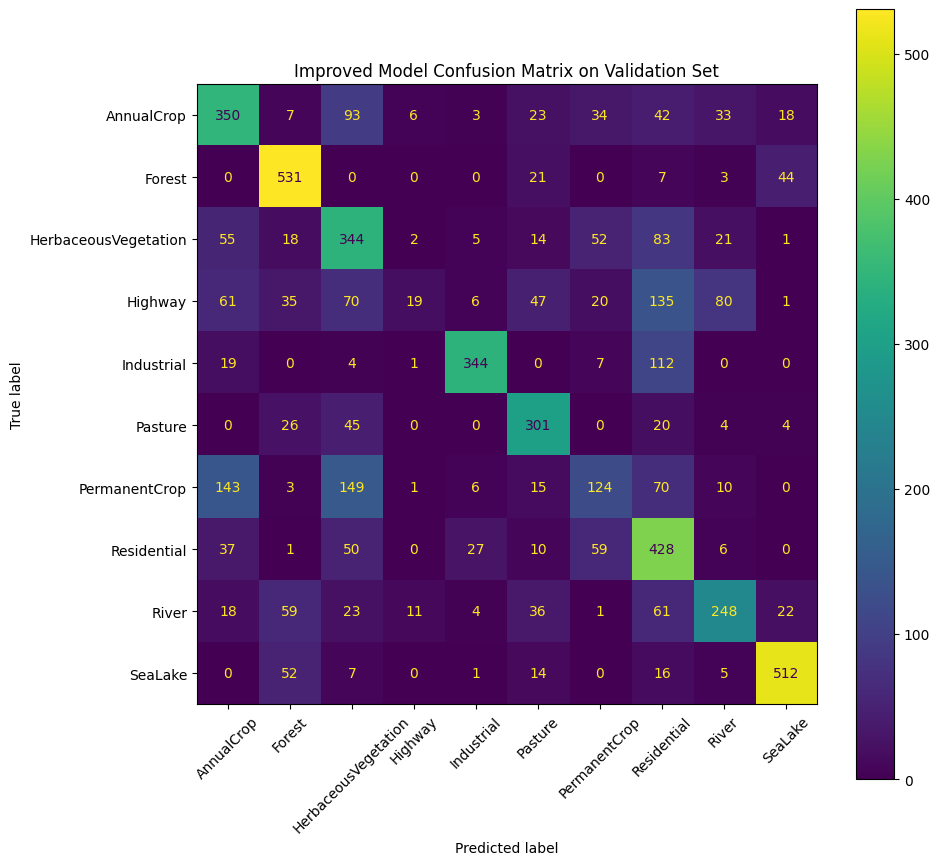

Training Accuracy Improvement: 29.65%
Validation Accuracy Improvement: 14.43%
Difference between Improved Model Training and Validation Accuracies: 17.56%


In [19]:
#NOTE: IGNORE THIS CODE: IT WAS JUST TO HELP ME FIND THE BEST HYPERPARAMETERS

rf_clf2 = ''
### YOUR CODE HERE ###

# Improved model:

# Parameter grid to try
n_estimators_options = [50, 100, 150]
max_depth_options = [6, 8, 10]
min_samples_split_options = [10, 15, 20]
min_samples_leaf_options = [3, 5, 8, 10]

best_val_accuracy = 0
best_model = None
best_params = {}

# Loop through all parameter combinations
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        for min_samples_split in min_samples_split_options:
            for min_samples_leaf in min_samples_leaf_options:

                rf_clf2 = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=1234,
                    n_jobs=1
                )
                # Train the improved model on training data:
                rf_clf2.fit(X_train_re, y_train)
                y_train_pred2 = rf_clf2.predict(X_train_re)
                y_val_pred2 = rf_clf2.predict(X_val_re)

                # Evaluate accuracies on train and validation data:
                train_accuracy2 = accuracy_score(y_train, y_train_pred2)
                val_accuracy2 = accuracy_score(y_val, y_val_pred2)
                diff = abs(train_accuracy2 - val_accuracy2) * 100

                # Save the model if it has the highest validation accuracy so far
                if val_accuracy2 > best_val_accuracy and abs(train_accuracy2 - val_accuracy2) >= .1:
                    best_val_accuracy = val_accuracy2
                    best_model = rf_clf2
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'train_accuracy': train_accuracy2,
                        'val_accuracy': val_accuracy2,
                        'difference': diff
                    }

                print("Run with parameters: n_estimators={}, max_depth={}, min_samples_split={}, min_samples_leaf={}".format(
                    n_estimators, max_depth, min_samples_split, min_samples_leaf))
                print("Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Difference: {:.2f}%".format(
                    train_accuracy2 * 100, val_accuracy2 * 100, diff))
                print("---------------------------------------------------------------------")


# Print the best hyperparameters and the corresponding performance metrics
print("Best Model Hyperparameters and Performance:")
print("n_estimators:", best_params['n_estimators'])
print("max_depth:", best_params['max_depth'])
print("min_samples_split:", best_params['min_samples_split'])
print("min_samples_leaf:", best_params['min_samples_leaf'])
print("Improved Model Training Accuracy: {:.2f}%".format(best_params['train_accuracy'] * 100))
print("Improved Model Validation Accuracy: {:.2f}%".format(best_params['val_accuracy'] * 100))
print("Difference between Training and Validation Accuracies for Improved Model: {:.2f}%".format(best_params['difference']))

# Compute the confusion matrix for the validation set:
cm2 = confusion_matrix(y_val, best_model.predict(X_val_re))
print("Improved Model Confusion Matrix:\n", cm2)

# Plot the confusion matrix for the improved model:
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp2.plot(ax=ax)
plt.title("Improved Model Confusion Matrix on Validation Set")
plt.xticks(rotation=45)
plt.show()

# Print improvements in percentage points:
train_improvement = (best_params['train_accuracy'] - train_accuracy) * 100
val_improvement = (best_params['val_accuracy'] - val_accuracy) * 100
print("Training Accuracy Improvement: {:.2f}%".format(train_improvement))
print("Validation Accuracy Improvement: {:.2f}%".format(val_improvement))

# Print performance gap between training and validation for improved model:
performance_gap = abs(best_params['train_accuracy'] - best_params['val_accuracy']) * 100
print("Difference between Improved Model Training and Validation Accuracies: {:.2f}%".format(performance_gap))

Improved Model Training Accuracy: 0.6346604938271605
Improved Model Validation Accuracy: 0.5525925925925926
Improved Model Confusion Matrix:
 [[337   7 105   2   0  21  33  54  30  20]
 [  0 517   1   0   0  21   0   7   4  56]
 [ 69  19 306   2   2  13  47 106  29   2]
 [ 59  42  79   4   6  40  18 142  81   3]
 [ 18   0   4   0 338   0   6 120   1   0]
 [  0  33  51   0   1 265   0  26   8  16]
 [177   3 142   0   2  19  85  83   9   1]
 [ 52   1  49   0  26   5  45 430  10   0]
 [ 14  62  29   4   3  31   0  87 226  27]
 [  0  65  11   0   1  30   1  17   6 476]]


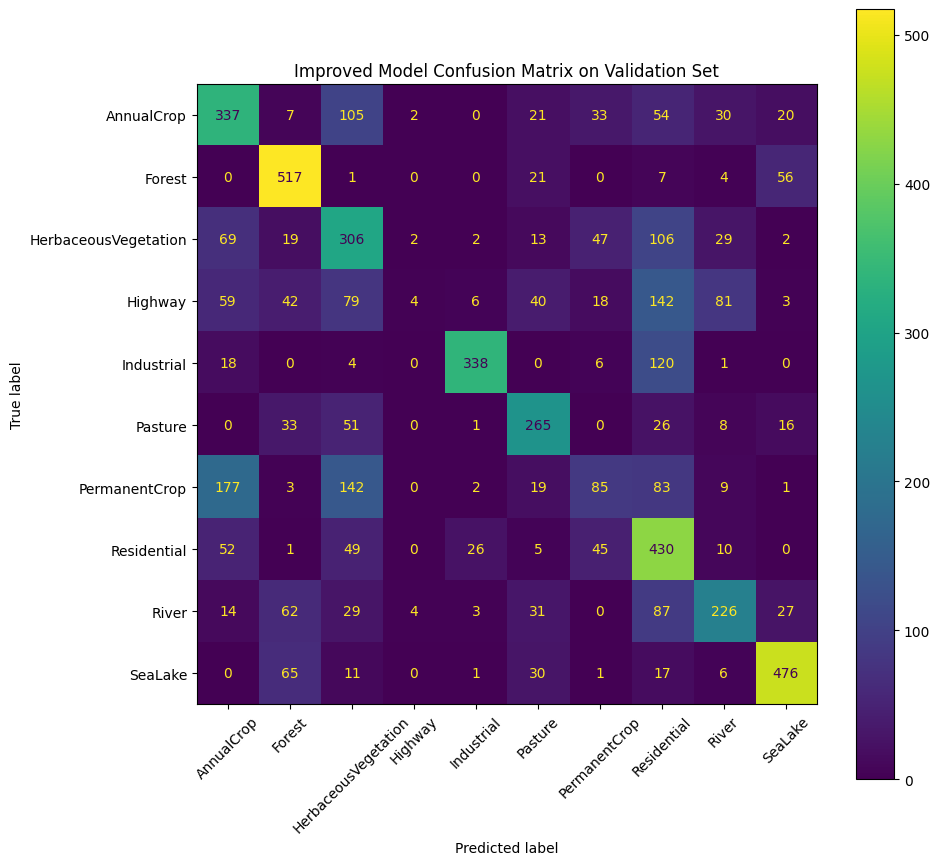

Training Accuracy Improvement: 16.29%
Validation Accuracy Improvement: 10.41%
Difference between Improved Model Training and Validation Accuracies: 8.21%


In [16]:
rf_clf2 = ''
### YOUR CODE HERE ###

# Improved model:
rf_clf2 = RandomForestClassifier(
    n_estimators=100,       # Increased from 2 to 100 for stronger ensemble
    max_depth=8,            # Retained tree depth
    min_samples_split=15,   # Require at least 15 samples to split an internal node
    min_samples_leaf=3,     # Require at least 3 samples at a leaf node to avoid overfitting
    random_state=1234,
    n_jobs=1
)

# Train the improved model on training data:
rf_clf2.fit(X_train_re, y_train)
y_train_pred2 = rf_clf2.predict(X_train_re)
y_val_pred2 = rf_clf2.predict(X_val_re)

# Evaluate accuracies on train and validation data:
train_accuracy2 = accuracy_score(y_train, y_train_pred2)
val_accuracy2 = accuracy_score(y_val, y_val_pred2)
print("Improved Model Training Accuracy:", train_accuracy2)
print("Improved Model Validation Accuracy:", val_accuracy2)

# Compute the confusion matrix for the validation set:
cm2 = confusion_matrix(y_val, y_val_pred2)
print("Improved Model Confusion Matrix:\n", cm2)

# Plot the confusion matrix for the improved model:
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp2.plot(ax=ax)
plt.title("Improved Model Confusion Matrix on Validation Set")
plt.xticks(rotation=45)
plt.show()

# Print improvements in percentage points:
train_improvement = (train_accuracy2 - train_accuracy) * 100
val_improvement = (val_accuracy2 - val_accuracy) * 100
print("Training Accuracy Improvement: {:.2f}%".format(train_improvement))
print("Validation Accuracy Improvement: {:.2f}%".format(val_improvement))

# Print performance gap between training and validation for improved model:
performance_gap = abs(train_accuracy2 - val_accuracy2) * 100
print("Difference between Improved Model Training and Validation Accuracies: {:.2f}%".format(performance_gap))

In [17]:
# Compute per-class accuracy for the baseline model using its confusion matrix
baseline_per_class_acc = np.diag(cm)/np.sum(cm, axis=1)
# Compute per-class accuracy for the improved model using its confusion matrix
improved_per_class_acc = np.diag(cm2)/np.sum(cm2, axis=1)

# Create df to compare the per-class accuracies and improvements
df_compare = pd.DataFrame({
    'Class': encoder.classes_,
    'Baseline Accuracy': baseline_per_class_acc,
    'Improved Accuracy': improved_per_class_acc,
    'Accuracy Improvement': improved_per_class_acc - baseline_per_class_acc
})

# Sort by improved accuracy to see most confused classes
df_compare_sorted = df_compare.sort_values(by='Improved Accuracy', ascending=True)
df_compare_sorted

,Class,Baseline Accuracy,Improved Accuracy,Accuracy Improvement
3,Highway,0.031646,0.008439,-0.023207
6,PermanentCrop,0.117083,0.163148,0.046065
8,River,0.351967,0.467909,0.115942
2,HerbaceousVegetation,0.473950,0.514286,0.040336
0,AnnualCrop,0.428571,0.553366,0.124795
5,Pasture,0.502500,0.662500,0.160000
4,Industrial,0.431211,0.694045,0.262834
7,Residential,0.449838,0.695793,0.245955
9,SeaLake,0.761120,0.784185,0.023064
1,Forest,0.795380,0.853135,0.057756


How your implementation is different compared to the baseline classifier: [In the improved model, I refined the Random Forest classifier only by tuning hyperparameters through a grid search approach, rather than using fixed parameters provided as in the baseline. I found the model that performed best (with no more than a 10% difference between train and validation sets) had the following hyperparameter configuration: 100 n_estimators, 8 max_depth, 15 min_samples_split, and 3 min_samples_leaf. Thus, the improved model has an increased number of trees, retained maximum depth, and higher minimum sample requirements for splits and leaves, which has enabled the model to capture patterns in the data better while avoiding overfitting.


Comment on training vs. validation performance relative to baseline model: [The improved model achieved a training accuracy of about 63.47% and a validation accuracy of 55.26%, which represent improvements of roughly 16.29% and 10.41% over the baseline, respectively. Although the gap between training and validation accuracies is 8.21%, which is within the provided acceptable range, the larger boost in training accuracy (compared to validation score boost) indicates that the model is learning more complex features from the training data (overfitting). Still, the improvements in both metrics imply better overall performance and generalization compared to the baseline.]

Comment on the classes the model confuses the most relative to the baseline:[We find that, while the improved model has improved accuracies for most classes, it still struggles significantly with the 'Highway' class, whose accuracy dropped from 3.16% in the baseline to 0.84% in the improved model. Also, classes like 'PermanentCrop' and 'River' show only modest improvements, indicating that the visual features distinguishing these classes remain challenging for the model. The continued confusion could be due to the reasons suggested in the prior answer (overlapping  characteristics, visually or contextually), maybe suggesting that, in preprocessing, there is a need for more data augmentation for these specific categories.]

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [18]:
### YOUR CODE HERE ###
y_test_pred2 = rf_clf2.predict(X_test_re)
test_accuracy2 = accuracy_score(y_test, y_test_pred2)

print("Improved Model Training Accuracy: {:.2f}%".format(train_accuracy2 * 100))
print("Improved Model Validation Accuracy: {:.2f}%".format(val_accuracy2 * 100))
print("Improved Model Test Accuracy: {:.2f}%".format(test_accuracy2 * 100))

# Calculate differences in accuracy (in percentage points)
train_test_diff = abs(train_accuracy2 - test_accuracy2) * 100
val_test_diff = abs(val_accuracy2 - test_accuracy2) * 100

print("Difference between Training and Test Accuracy: {:.2f}%".format(train_test_diff))
print("Difference between Validation and Test Accuracy: {:.2f}%".format(val_test_diff))

Improved Model Training Accuracy: 63.47%
Improved Model Validation Accuracy: 55.26%
Improved Model Test Accuracy: 55.74%
Difference between Training and Test Accuracy: 7.73%
Difference between Validation and Test Accuracy: 0.48%


Comment on test set accuracy vs. training vs. validation set accuracy: [Compared to the training and validation performances, the test set accuracy of 55.74% is very close to the validation accuracy of 55.26%, differing by only 0.48%, which strongly indicates that the model generalizes well to unseen data (at least as well as the validation data). Although the training accuracy is higher at 63.47%, reflecting a tighter fit to the training data, the 7.73% gap between training and test accuracies is within the stated 10% range, suggesting that overfitting is being controlled enough. Still, the performance on any of the datasets is pretty poor, and should be improved with further data preprocessing or model selection (or potential additional hyperparameter tuning).]


---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

In [19]:
### YOUR ANSWER HERE ###
print("""Decision Forests are a very interpretable baseline for land cover
classification because they can handle high-dimensional data and are pretty
easy to tune the hyperparameters. This making them suitable for initial experiments.
Being ensemble models helps to reduce overfitting, and they help to understand feature
importance. However, while they work well on structured features, they may not be
capturing the intricate patterns present as effectively as deep learning models can,
such as FFNNs and CNNs (like we did the eye images). Thus, I recommend using a
Decision Forest as the starting baseline model and to understand which features to
use in the final model, but then to switch to a deep learning model for better performance.
If deep learning models would take too long to train, Gradient Boosting Algorithms
like XGBoost may also perform slightly better.""")


Decision Forests are a very interpretable baseline for land cover 
classification because they can handle high-dimensional data and are pretty 
easy to tune the hyperparameters. This making them suitable for initial experiments. 
Being ensemble models helps to reduce overfitting, and they help to understand feature 
importance. However, while they work well on structured features, they may not be 
capturing the intricate patterns present as effectively as deep learning models can, 
such as FFNNs and CNNs (like we did the eye images). Thus, I recommend using a 
Decision Forest as the starting baseline model and to understand which features to 
use in the final model, but then to switch to a deep learning model for better performance.
If deep learning models would take too long to train, Gradient Boosting Algorithms
like XGBoost may also perform slightly better.


#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

In [20]:
### YOUR ANSWER HERE ###
print("""As stated in Exercise 9, while the Decision Forest classifier offers a
good baseline model and good understanding of feature importance, I would propose
using a FFNN or CNN to further improve performance on land cover classification.
These deep learning models (specifically CNNs) are specifically designed for image
data, allowing them to automatically learn and extract complex patterns. This
enables CNNs to capture small differences in texture, color, structure, etc.
that are often important for accurately distinguishing between land cover classes
and that the Decision Forest Classifier won't. As a result, CNNs will likely outperform
the Decision Forests on this task. And again, if deep learning models would take
too long to train, Gradient Boosting Algorithms like XGBoost may also perform
slightly better.""")


As stated in Exercise 9, while the Decision Forest classifier offers a 
good baseline model and good understanding of feature importance, I would propose 
using a FFNN or CNN to further improve performance on land cover classification. 
These deep learning models (specifically CNNs) are specifically designed for image 
data, allowing them to automatically learn and extract complex patterns. This 
enables CNNs to capture small differences in texture, color, structure, etc.
that are often important for accurately distinguishing between land cover classes
and that the Decision Forest Classifier won't. As a result, CNNs will likely outperform 
the Decision Forests on this task. And again, if deep learning models would take 
too long to train, Gradient Boosting Algorithms like XGBoost may also perform 
slightly better.


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [ ]:
### YOUR CODE HERE ###